## Prepare for the envrioment
Load the libraries and packages

In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from gprofiler import GProfiler
import seaborn as sns

import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

In [2]:
sample_strings = ['Duo_M1', 'Duo_M2', 'Jej_M1', 'Jej_M2', 'Il_M1', 'Il_M2']
sample_id_strings = ['3', '4', '5', '6', '7', '8']
file_base = '/home/yiyang/github/MD/data/GSE92332_uncompressed/GSM283657'
exp_string = '_Regional_'
data_file_end = '_matrix.mtx'
barcode_file_end = '_barcodes.tsv'
gene_file_end = '_genes.tsv'
cc_genes_file = '/home/yiyang/github/MD/data/Macosko_cell_cycle_genes.txt'


In [3]:

# Initialize a dataset adatas to store the dataset
adatas = []

for sample, sample_id in zip(sample_strings, sample_id_strings):
    # 解析文件名
    data_file = f"{file_base}{sample_id}{exp_string}{sample}{data_file_end}"
    barcode_file = f"{file_base}{sample_id}{exp_string}{sample}{barcode_file_end}"
    gene_file = f"{file_base}{sample_id}{exp_string}{sample}{gene_file_end}"
    
    # Load data
    adata = sc.read(data_file, cache=True).transpose()
    adata.X = adata.X.toarray()

    barcodes = pd.read_csv(barcode_file, header=None, sep='\t')
    genes = pd.read_csv(gene_file, header=None, sep='\t')

    # Annotate data
    barcodes.rename(columns={0:'barcode'}, inplace=True)
    barcodes.set_index('barcode', inplace=True)
    adata.obs = barcodes
    adata.obs['sample'] = sample
    adata.obs['region'] = sample.split("_")[0]
    adata.obs['donor'] = sample.split("_")[1]

    genes.rename(columns={0:'gene_id', 1:'gene_symbol'}, inplace=True)
    genes['gene_symbol'] = genes['gene_symbol'].str.replace('^mm10_', '', regex=True)
    genes.set_index('gene_symbol', inplace=True)
    adata.var = genes

    adata.var_names_make_unique()

    adatas.append(adata)

# combine all the data
adata = adatas[0].concatenate(adatas[1:], batch_key='sample_id')

if 'gene_id-1' in adata.var.columns:
    adata.var['gene_id'] = adata.var['gene_id-1']
    adata.var.drop(columns=['gene_id-1', 'gene_id-0'], inplace=True)

adata.obs.drop(columns=['sample_id'], inplace=True)
adata.obs_names = [c.split("-")[0] for c in adata.obs_names]
adata.obs_names_make_unique(join='_')

print(f"Load data finished. There are {adata.n_obs} cells and  {adata.n_vars} genes.")
adata.write('/home/yiyang/github/MD/data/mouse_intestinal_epithelium.h5ad')


/tmp/ipykernel_906839/1250256111.py:35: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adatas[0].concatenate(adatas[1:], batch_key='sample_id')


Load data finished. There are 13353 cells and  27998 genes.


In [4]:
print("region:")
print(adata.obs['region'].value_counts())
print("\n" + "="*50 + "\n")

print("donor:")
print(adata.obs['donor'].value_counts())
print("\n" + "="*50 + "\n")

print("sample:")
print(adata.obs['sample'].value_counts())
print("\n" + "="*50 + "\n")


region:
region
Duo    4554
Jej    4496
Il     4303
Name: count, dtype: int64


donor:
donor
M2    6711
M1    6642
Name: count, dtype: int64


sample:
sample
Jej_M2    2668
Il_M1     2466
Duo_M1    2348
Duo_M2    2206
Il_M2     1837
Jej_M1    1828
Name: count, dtype: int64




## Quality control
Accroding to the information, I found we usually use mitochondrial genes as a very important reference, and when there are too many mitochondrial genes it is usually assumed that the cell is under stress or dying.

### MT fraction part

In [5]:
# Calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)

mt_gene_mask = [gene.startswith('mt-') for gene in adata.var_names]
adata.obs['mt_frac'] = adata.X[:, mt_gene_mask].sum(1)/adata.obs['n_counts']

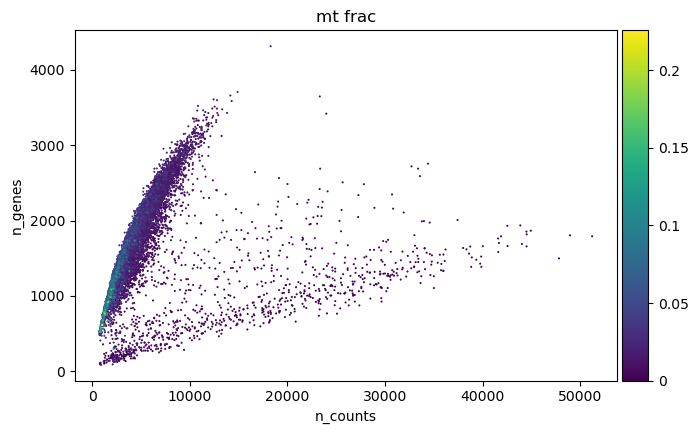

In [6]:
#Data summary plots
p1 = sc.pl.scatter(adata, 'n_counts', 'n_genes', color='mt_frac')


From this plot, we can see that cells with lower counts and genes tend to have a higher fraction of mitochondrial counts. We can think these cells are likely under stress or are dying. To have a deeper look, we should focus on this part.

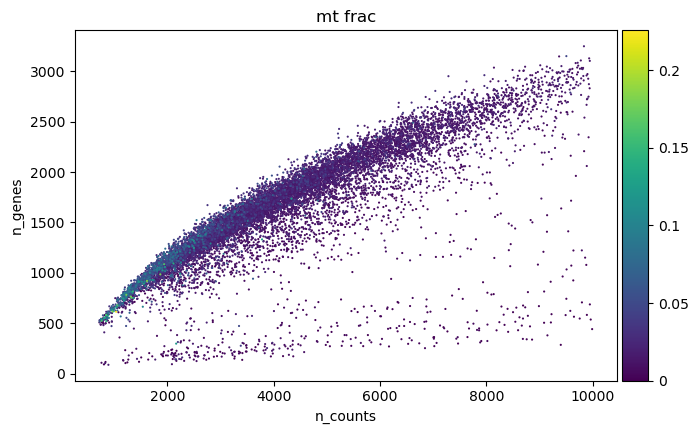

In [7]:
p2 = sc.pl.scatter(adata[adata.obs['n_counts']<10000], 'n_counts', 'n_genes', color='mt_frac')

This plot can help us focus on the high MT fraction part. This can also prove our perspective, cells with lower counts and genes tend to have a higher fraction of mitochondrial counts. So next step is to filter these parts.

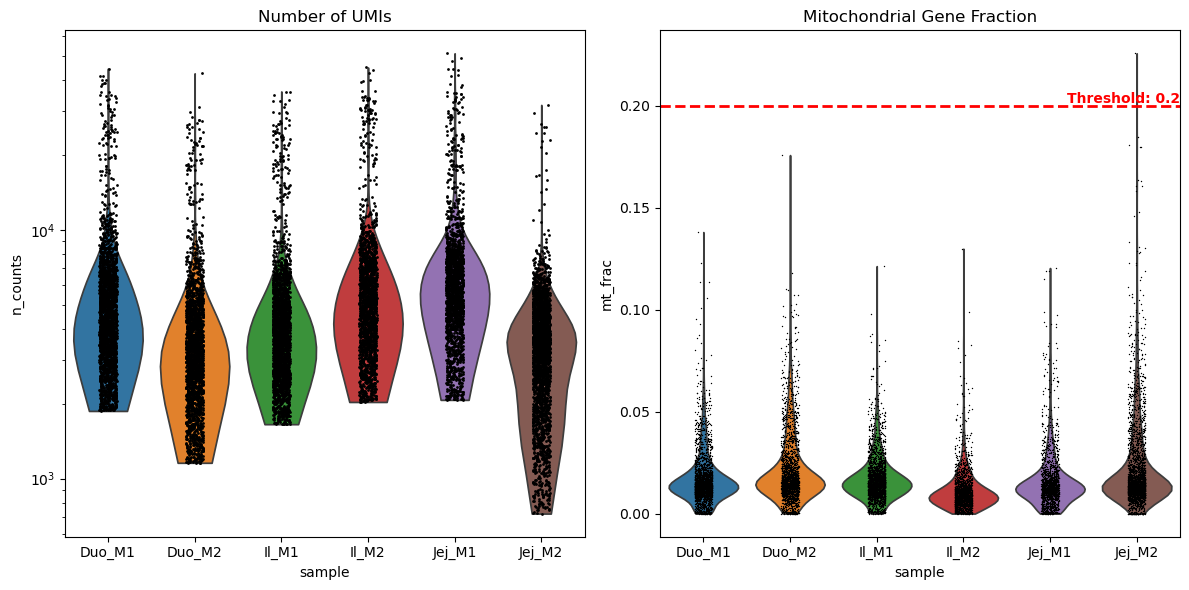

In [8]:
mt_threshold = 0.20

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

sc.pl.violin(adata, 'n_counts', groupby='sample', size=2, log=True, cut=0, ax=ax1, show=False)
ax1.set_title('Number of UMIs')

sc.pl.violin(adata, 'mt_frac', groupby='sample', ax=ax2, show=False)
ax2.set_title('Mitochondrial Gene Fraction')

ax2.axhline(y=mt_threshold, color='red', linestyle='--', linewidth=2)

ax2.text(ax2.get_xlim()[1], mt_threshold, f'Threshold: {mt_threshold}', 
         ha='right', va='bottom', color='red', fontweight='bold')

plt.tight_layout()

plt.show()

We can see the right panel, there are only a few samples are under stress or dying. But there is also another important reference is the counts. Our original goal was definitely to include as many cells as possible, but sometimes too many or too few can lead to problems in our downstream analysis, so choosing the right number is also an important aspect. From the left panel we can see that many samples have UMI counts well above or below the main distribution, which may indicate that these cells are abnormal or of poor quality. Now we will foces on the **count** and **genes**.

### The UMI counts part
Histograms are a great tool for us to observe the effects of cell counting.

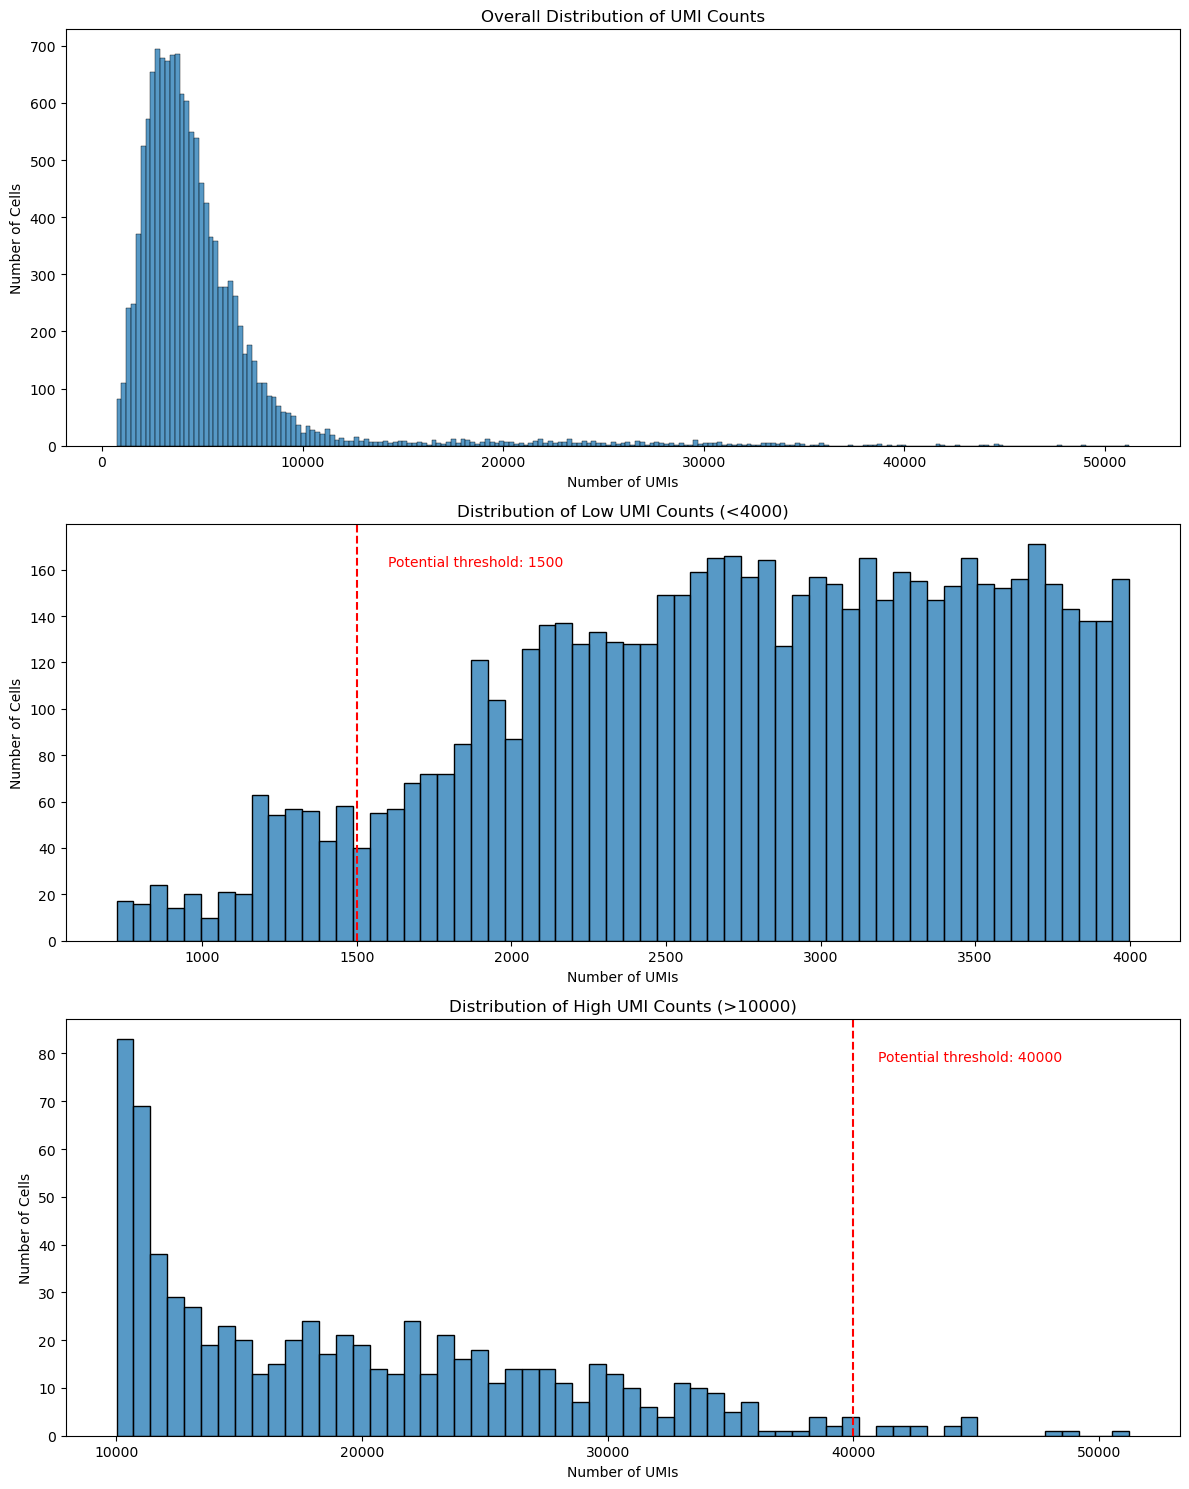

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15))

# Overall distribution
sns.histplot(adata.obs['n_counts'], kde=False, ax=ax1)
ax1.set_title('Overall Distribution of UMI Counts')
ax1.set_xlabel('Number of UMIs')
ax1.set_ylabel('Number of Cells')

# Low count distribution
sns.histplot(adata.obs['n_counts'][adata.obs['n_counts'] < 4000], kde=False, bins=60, ax=ax2)
ax2.set_title('Distribution of Low UMI Counts (<4000)')
ax2.set_xlabel('Number of UMIs')
ax2.set_ylabel('Number of Cells')
ax2.axvline(x=1500, color='r', linestyle='--')
ax2.text(1600, ax2.get_ylim()[1]*0.9, 'Potential threshold: 1500', color='r', rotation=0)

# High count distribution
sns.histplot(adata.obs['n_counts'][adata.obs['n_counts'] > 10000], kde=False, bins=60, ax=ax3)
ax3.set_title('Distribution of High UMI Counts (>10000)')
ax3.set_xlabel('Number of UMIs')
ax3.set_ylabel('Number of Cells')
ax3.axvline(x=40000, color='r', linestyle='--')
ax3.text(41000, ax3.get_ylim()[1]*0.9, 'Potential threshold: 40000', color='r', rotation=0)

plt.tight_layout()
plt.show()

There are two small peaks of groups of cells with fewer than 1500 counts. which are likely uninformative given the overall distribution of counts. This may be cellular debris found in droplets. The other peak at 20,000 counts. We estimate this population to range until 40,000 counts. This estimation is performed by visually tracing a Gaussian around the population.

### The gene parts


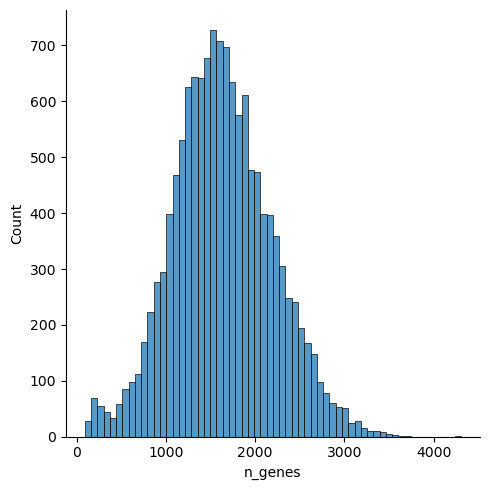

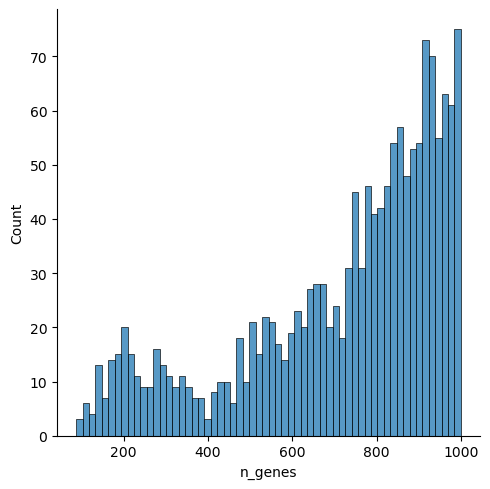

In [10]:
p6 = sb.displot(adata.obs['n_genes'], kde=False, bins=60)
plt.show()

p7 = sb.displot(adata.obs['n_genes'][adata.obs['n_genes']<1000], kde=False, bins=60)
plt.show()

Two populations of cells with low gene counts can be seen in the above plots. We decide to filter out cells with fewer than 700 genes expressed. Below this we are likely to find dying cells or empty droplets with ambient RNA. 

Finally, my filter part is this:

In [11]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

# Counts
sc.pp.filter_cells(adata, min_counts = 1500)
sc.pp.filter_cells(adata, max_counts = 40000)

# MT frac
adata = adata[adata.obs['mt_frac'] < 0.2]

# Gene
sc.pp.filter_cells(adata, min_genes = 700)

print('Number of cells after filter: {:d}'.format(adata.n_obs))

Total number of cells: 13353


/home/yiyang/anaconda3/envs/scRNA-seq/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:166: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


Number of cells after filter: 12457


We also need to filter the genes that ther are not detected in at least 20 cells. Because these genes are too few so we can think they will not have much influence on our analysis.

In [12]:
sc.pp.filter_genes(adata, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Number of genes after cell filter: 12818
